# Introduction to NLP using Fastai
> Implementing and decoding the revolutionary [ULMFiT](https://arxiv.org/abs/1801.06146) approach to train a language model on any downstream NLP task.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Harish Vadlamani
- categories: [Natural Language Processing, Sentiment Analysis]

---

In continuation to my previous posts [1](https://harish3110.github.io/through-tinted-lenses/fastai/image%20classification/2020/03/29/Building-an-image-classifier-using-Fastai-V2.html), [2](https://harish3110.github.io/through-tinted-lenses/fastai/image%20classification/model%20fine-tuning/2020/04/10/Improving-baseline-model.html), which delved into the domain of computer vision by building and fine-tuning an image classification model using Fastai, I would like to venture into the fascinating domain of Natural Language Processing using Fastai.

For this post we'll be working on the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) competition dataset on Kaggle to build a text classifier to distinguish between normal tweets and tweets sent out during a natural disaster using the [ULMFiT](https://arxiv.org/abs/1801.06146) approach and decoding this revolutionary paper that changed the NLP schenario for the better in the recent years.

In [4]:
#collapse

# Installing and importing the necessary libraries 
!pip install fastai2 --quiet
!pip install kaggle --quiet

from fastai2.text.all import *

import warnings
warnings.filterwarnings('ignore')

---

## Dataset Download and  basic EDA
> Using Kaggle API to download the competition dataset and view the data

In [5]:
# Using the kaggle api to search the name of the competition dataset to download
!kaggle competitions list -s 'nlp'

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
nlp-getting-started                                2030-01-01 00:00:00  Getting Started      Kudos       1577            True  
trec-covid-information-retrieval                   2020-06-03 11:00:00  Research             Kudos         19           False  
google-quest-challenge                             2020-02-10 23:59:00  Featured           $25,000       1571           False  
jigsaw-unintended-bias-in-toxicity-classification  2019-07-18 19:35:00  Featured           $65,000       3165           False  
gendered-pronoun-resolution                        2019-04-22 23:59:00  Research           $25,000        838           False  
word2vec-nlp-tutorial                              2015-06-30 23:59:00  Getting Started  Knowledge      

The competition dataset we would like to download is the 1st one titled `nlp-getting-started`

In [8]:
%cd ~/Desktop/datasets
dataset = 'nlp-getting-started'

# Creating a folder for the dataset
!mkdir {dataset}
%cd {dataset}

# Using the Kaggle API to download dataset
!kaggle competitions download -c {dataset}

/home/harish3110/Desktop/datasets
/home/harish3110/Desktop/datasets/nlp-getting-started
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 2.11MB/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 2.10MB/s]


In [9]:
# Unzip the dataset and delete the respective zip file

!unzip {dataset + '.zip'}
!rm {dataset + '.zip'} 

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [10]:
# View the files

!ls

sample_submission.csv  test.csv  train.csv


In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.head() 

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [13]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
#hide_input
print(f'The training set has {len(train)} records.')
print(f'The test set has {len(test)} records.')

The training set has 7613 records.
The test set has 3263 records.


---

## The ULMFiT approach

The Universal Language Model Fine-tuning (ULMFiT) is an inductive transfer learning approach developed by Jeremy Howard and Sebastian Ruder to all the tasks in the domain of natural language processing which sparked the usage of transfer learning in NLP tasks. 

**The ULMFiT approach to training NLP models is heralded as the ImageNet moment in the domain of Natural Language Processing** 

The model architecture used in the entire process of the ULMFiT approach is ubiquitous and is the well-known **AWD-LSTM** architecture. 

The ULMFiT approach can be braodly explained in the 3 major steps as shown below:

![](https://miro.medium.com/max/2000/1*9n9yv4EalUn76yP1Yffhfw.png 'The ULMFiT Process')

---

### Step 1: Training a general corpus language model

A language model is first trained on a corpus of Wikipedia articles known as Wikitext-103 using a **self-supervised approach**, i.e. using the training labels in itself to train models, in this case training a LM to learn to predict the next word in a sequence. This resulting LM learns the semantics of the english language and captures general features in the different layers. 

This pretrained language model is trained on 28,595 Wikipedia articles and training process is very expensive and time consuming and is luckily open-sourced in the Fastai library for us to use. 

---

### Side Note: Text Pre-processing
>Transforming and normalizing texts such that it can be trained on a neural network for language modeling

In my previous post, [Building an image classifier using Fastai V2](https://harish3110.github.io/through-tinted-lenses/fastai/image%20classification/2020/03/29/Building-an-image-classifier-using-Fastai-V2.html#1.-Create-a-DataBlock:) we look at the datablock API of Fastai and where we apply the `resize` transform that ensures that all images used for training the image classifier model are resized to the same dimensions in order to be able to collate them in the GPU.

The same type of pre-processing needs to be done for texts in order to train a language model. Whether it's the articles in the Wikipedia 103 dataset or tweets in disaster dataset are of different lengths and can be very long. Thus the tweets corpus i.e. the dataset needs to pre-processed correctly in order to train a neural network on text data. 

There are many ways the pre-processing for textual data can be done and Fastai approach is to apply the following 2 main transforms to texts:

---
***Note:*** A transform in Fastai is basically an **almost** reversible function that transforms data into another form(encoding) and also has the capability of getting back the original data(decoding) if needed. 

---

##### 1. Tokenization

The first step is to gather all the unique `tokens` in the corpus being used. 

A `token` can be defined in numerous ways depedning on the person creating the language model based on the granularity level i.e. the smallest part of the text they would like to consider. In the simplest scenario, a word can be considered as the token.

So the idea is to get a list of all the unique words used in the general domain corpus(Wikipedia 103 dataset) and our added downstream dataset(Disaster tweets dataset) to build a vocabulary for training our language model.

In [48]:
# Let's take an example text from our training set to show a tokenization example

txt = train['text'].iloc[0]
txt

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [47]:
# Initializing the default tokenizer used in Fastai which is that of Spacy called `WordTokenizer`
spacy = WordTokenizer() 

# Wrapping the Spacy tokenizer with a custom Fastai function to make some custom changes to the tokenizer
tkn = Tokenizer(spacy) 

tkn(txt)

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [60]:
# Setting up a tokenizer on the entire dataframe 'df_lm'
tok = Tokenizer.from_df(df_lm)
tok.setup(train)
toks = txts.map(tok)
toks[0]

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

---
**Note:** The special tokens you can see above starting with 'xx' are special fastai tokens added on top of the spacy tokenizer used to indicate certain extra meanings in the text data as follows:

- `xxbos`:: Indicates the beginning of a text (here, a review)
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the next word is unknown

---

As mentioned above `Tokenizer` is a Fastai transform, which is basically a function with and `encodes` and `decodes` method available to tokenize a text and return it back to **almost** the same initial state.

In [64]:
tok.encodes(toks[0])

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [59]:
tok.decode(toks[0])

'xxbos xxmaj our xxmaj deeds are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all'

The reason we don't get the original string back when applying `decode` is because the default tokenizer used in this case isn't `reversible`. 

##### 2. Numericalization

The next step in the pre-processing step is to index the tokens created earlier so that they can easily accessed. 

In [56]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([  2,   8, 150,   8,   0,  43,  14,   8, 884,  19])

In [67]:
num.encodes(toks[0])

TensorText([   2,    8,  150,    8,    0,   43,   14,    8,  884,   19,   39,   13,
         300,    8,  169,    7, 1620,    8,    0,  120,   65])

In [57]:
num.decode(nums[0][:10])

(#10) ['xxbos','xxmaj','our','xxmaj','xxunk','are','the','xxmaj','reason','of']

---

### Step 2: Fine-tuning pretrained LM to downstream dataset

Despite having a vast language model pre-trained, it's always likely that the specific downstream task we would like to build our NLP model is a part of a slightly different distribution and thus  need to fine-tune this Wikitext 103 LM.

This step is much faster and it converges much faster as there will be an overlap to the general domain dataset. It only needs to adapt to the idiosyncrasies of the language used and not learn the language per say. 

Since NLP models are more shallow in comparison to a computer vision model, the fine-tuning approaches need to be different and thus the paper provides novel fine-tuning techniques to do so:

#### Discriminative Fine-tuning

Since different layers of the model capture different types of information and thus they should be fine-tuned to different extents. 

This idea is similar as the use of discriminative learning rates used in CV applications which I explained in detail in my previous [post](https://harish3110.github.io/through-tinted-lenses/image%20classification/2020/04/10/Improving-baseline-model.html#Discriminative-learning-rates).

#### Slanted Learning Rates

The idea behind slanted learning rates is that for a pretrained language model to adpat/fine-tune itself to the downstream dataset, the fine-tuning process should ideally converge faster to asuitable region in the parameter space and thern refine its parameters there. 

So the slanted learning rates approach first linearly increases the learning rates for a short period and then linearly decays the learning rate slowly which is a modification of of Leslie Smith's traingular learning rate approache where the increase and decrease is almost the same. 

![](https://miro.medium.com/max/1096/1*QptmUluWXteT6oI5bD22rw.png 'Slanted Triangular Learning Rates')

#### Creating a dataloader
> Putting the pre-processed data in batches of text sequences for fine-tuning the language model

In [10]:
# dataset for fine-tuning language model which only needs the text data

df_lm = pd.concat([train, test], axis=0)[['text']]
df_lm.head()

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


---
***Note:*** An important trick used in creating a dataloader here is that we use all the data available to us i.e train and test data. In case we had a dataset with unlabeled reviews we could also use that to fine-tune the pre-trained model better since this step doesn't need labels and is self-supervised. 

---

Creating a dataloader for self-supervised learning task which tries to predict the next word in a sequence as represented by `text_` below. 

**Fastai handles text processing steps like tokenization and numericalization internally when `TextBlock` is passed to `DataBlock`.**

In [11]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [12]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

---
***Note:***

- Select the batch size `bs` based on how much your GPU can handle without running out of memory
- The sequence length `seq_len` for the data split used here is the default sequence length used for training the Wikipedia 103 language model

---

In [13]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos xxmaj put the xxup right person up on the block # xxmaj shelli xxrep 3 ? xxmaj the sense of xxunk is ridiculous . # xxup bb17 . xxbos xxunk xxup dw was on his way to a better career than xxmaj xxunk and that was n't derailed until 2014 . xxmaj shame . xxbos xxmaj wreckage ' conclusively xxmaj confirmed ' as xxmaj from xxup mh370 : xxmaj malaysia xxup pm : xxmaj investigators and the families of,xxmaj put the xxup right person up on the block # xxmaj shelli xxrep 3 ? xxmaj the sense of xxunk is ridiculous . # xxup bb17 . xxbos xxunk xxup dw was on his way to a better career than xxmaj xxunk and that was n't derailed until 2014 . xxmaj shame . xxbos xxmaj wreckage ' conclusively xxmaj confirmed ' as xxmaj from xxup mh370 : xxmaj malaysia xxup pm : xxmaj investigators and the families of those
1,xxmaj under a xxmaj minute http : / / t.co / xxunk xxbos xxmaj correction : xxmaj tent xxmaj collapse xxmaj story http : / / t.co / xxunk xxbos xxunk xxmaj xxunk not getting rid me until every last drop of life has gone … i xxunk into burning buildings because all xxmaj life matters . xxmaj xxunk xxbos xxmaj suicide bomber xxunk in xxmaj saudi xxmaj arabia mosque 17 reportedly killed http : / / t.co / xxunk,under a xxmaj minute http : / / t.co / xxunk xxbos xxmaj correction : xxmaj tent xxmaj collapse xxmaj story http : / / t.co / xxunk xxbos xxunk xxmaj xxunk not getting rid me until every last drop of life has gone … i xxunk into burning buildings because all xxmaj life matters . xxmaj xxunk xxbos xxmaj suicide bomber xxunk in xxmaj saudi xxmaj arabia mosque 17 reportedly killed http : / / t.co / xxunk xxbos
2,our true xxmaj hero 's ! ! xxmaj besides your music xxbos xxmaj if abortion is murder then xxunk are xxunk and xxunk is mass genocide . xxbos xxmaj fatality ! xxbos xxmaj interesting : xxup mh370 : xxmaj aircraft debris found on xxmaj la xxmaj reunion is from missing xxmaj malaysia xxmaj airlines … - xxup abc … http : / / t.co / xxunk xxmaj please xxup rt xxbos xxmaj rly tragedy in xxup mp : xxmaj some,true xxmaj hero 's ! ! xxmaj besides your music xxbos xxmaj if abortion is murder then xxunk are xxunk and xxunk is mass genocide . xxbos xxmaj fatality ! xxbos xxmaj interesting : xxup mh370 : xxmaj aircraft debris found on xxmaj la xxmaj reunion is from missing xxmaj malaysia xxmaj airlines … - xxup abc … http : / / t.co / xxunk xxmaj please xxup rt xxbos xxmaj rly tragedy in xxup mp : xxmaj some live


In [17]:
# Saving the dataloader for fast use in the future

torch.save(dls_lm, 'disaster_tweets_dls_lm.pkl')

In [18]:
# To load the Dataloaders in the future

dls_lm = torch.load('disaster_tweets_dls_lm.pkl')

#### Fine-tuning the language model

Fine-tuning Wikitext 103 based LM to disaster tweets using ULMFiT fine-tuning methodologies. This fine-tuned LM can thus be used as the base to classify disaster texts in the next step.

The common metric used in CV models is accuracy but in sequence based models we use something called **perplexity** which is basically exponential of the loss as follows:

```
torch.exp(cross_entropy)
```

In [70]:
#fine-tuning wikitext LM to disaster tweets dataset

learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [69]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5832, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5832, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5832, bias=True)
    (output_dp): RNNDropout()
  )
)

---
##### Embedding Layer

We can see that the above `AWD LSTM` architecture used in ULMFiT has a bunch of layers called **embedding** layers as the input here.

The pre-processed text and the batching of data using dataloaders is followed by passing this data into an embedding layer which can be considered as a small neural network by itself which is used to calculate token i.e. word dependencies in the dataset. These layers are trained along with the main neural network model and learns relationships between words in the dataset along the way. 

An embedding layer is a computationally efficient method to represent tokens in a lesser dimension space, being less sparse and as a look-up table for all tokens in our dataset which captures relationships between the tokens. 

It's a much more computationally efficient approach to the traditional `one-hot encoding` appraoch which can make these types of task really expensive and inefficient.

![](https://www.fast.ai/images/kittenavalanche.png "In the above embediing layer learned, vectors for baby animal words are closer together, and an unrelated word like 'avalanche' is further away")

If you would like to know more about word embedding check out this amazing [video](https://www.youtube.com/watch?v=25nC0n9ERq4) by Rachael Thomas, co-founder of Fastai.

---

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0831763744354248)

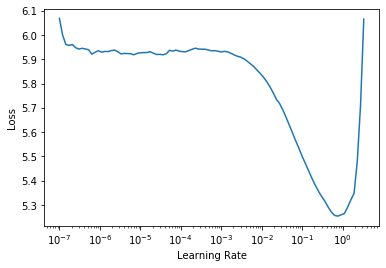

In [20]:
learn.lr_find()

Let's train the last layer of the model using a learning rate of `1e-2` based on the above learning rate finder plot using Leslie Smith's [1 Cycle Training](https://arxiv.org/abs/1708.07120) approach.

In [21]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.023802,3.831925,0.369296,46.151302,00:08


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.945078,3.558439,0.395056,35.108360,00:08
1,3.691576,3.303960,0.427633,27.220207,00:08
2,3.473612,3.195056,0.441754,24.411539,00:08
3,3.313620,3.149503,0.447472,23.324463,00:08
4,3.224377,3.142539,0.448976,23.162609,00:08


Once we have fine-tuned out LM to our downstream task, we save the `encoder` part of the model which portion of the model except the final layer that predicts the next word in the sequence. 

We can then use this`encoder` part, which is the portion that learns the language semantics, as our base to build a disaster tweets classification model. 

In [22]:
# Saving the encoder

learn.save_encoder('finetuned')

---

### Step 3: Training a classifier on the downstream NLP task

Now that we have a language model fine-tuned to our downstream NLP dataset we can use the encoder portion of the fine-tuned language model which is the part that learns the features of the language used in the downstream dataset as the base to build a text classifier for tasks such as sentiment analysis, spam detection, fraud detection, document classifcation etc. 

The encoder saved is then appended by a simple classifier consisting of two additional linear blocks consisting of the  standard batch normalization and dropout, with ReLU activations for the intermediate layer and a softmax activation at the last layer for the classification purpose. 

Fine-tuning a classifier is a very critical task in a transfer learning method and is the main reason why transfer learning approaches failed until ULMFiT came along. 

Overly aggressive fine-tuning can result in **catastrophic forgetting** and too cautious fine-tuning can lead to extremely slow convergence. 

To tackle this problem, ULMFiT introduces a novel fine-tuning technique in **gradual unfreezing** besides also using **slanted triangular learning rates** and **discriminative fine-tuning** to successfully train a classifier using a pre-trained LM.

#### Gradual Unfreezing

The idea behind gradual unfreezing is that fine-tuning a classifier on all layers can result in catastrophic forgetting and thus each layer staring form the las layer is trained one after the other by freezing all the lower layers and only training the layer in question. 

The paper empirically found that after training the last layer of the model with a learning rate of `lr`, the subsequent layers can be trained one after another by reducing `lr` by a factor of `2.6`.

#### Backpropagation Throught Time for Text Classification (BPT3C)

Since the model architecture for training and fine-tuning the language is that of an LSTM, the paper implements the backpropagation through time(BPTT) approach to be able propagate gradients without them exploding or vanishing. 

In the ULMFiT approach, a modification to the traditional BPTT is made specifically in the fine-tuning classifier phase called **BPTT for Text Classification(BPT3C)** to make fine-tuning a classifier for large documents feasible. 

Steps in BPT3C:
- The document is divided into fixed length batches of size 'b'. 
- At the beginning of each batch, the model is initiated with the final state of the previous batch by keeping track of the hidden states for mean and max-pooling. 
- The gradients are back-propagated to the batches whose hidden states contributed to the final prediction. 
- In practice, variable length back-propagation sequences are used. 


#### Concat Pooling

Since signals for classifying texts can exist anywhere and are not only limited to last word in the sequence, the ULMFiT approach also proposes to concatenate the last time step of the document by max-pooling and mean-pooling representations to provide more signal and better training

#### Creating the classifier dataloader

Ensure that the sequence length and vocab passed to the `TextBlock` is same as that given while fine-tuning LM 

In [23]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('target'),
                splitter=RandomSplitter(0.2))

In [24]:
dls = dls.dataloaders(train, bs=64)

In [25]:
dls.show_batch(max_n=3)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
2,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0


In [26]:
len(dls.train_ds), len(dls.valid_ds)

(6091, 1522)

#### Defining the learner

In [27]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1)]).to_fp16()
learn.load_encoder('finetuned')

In [28]:
#collapse-hide
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5832, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5832, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


#### Training the classifier
> Fine-tuning a text classifier using gradual unfreezing, slanted learning rates and discriminating learning techniques.

In [29]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.650071,0.471966,0.777267,0.706494,00:02


In [30]:
# Applying gradual unfreezing of one layer after another

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.564487,0.442714,0.796321,0.752000,00:02


In [31]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.500388,0.430654,0.801577,0.758786,00:02


In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.449139,0.438118,0.796978,0.756117,00:03
1,0.426530,0.435094,0.800920,0.772352,00:03


---

## Creating a Kaggle submission file

In [33]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [34]:
dl = learn.dls.test_dl(test['text'])

In [35]:
preds = learn.get_preds(dl=dl)

In [36]:
# Let's view the output of a single row of data

preds[0][0].cpu().numpy()

array([0.07068779, 0.9293122 ], dtype=float32)

In [38]:
# Since it's a multi-class problem and it uses softmax on the binary classes, 
# Need to calculate argmax of the output to get the best class as follows 

preds[0][0].cpu().argmax(dim=-1)

tensor(1)

In [38]:
sub['target'] = preds[0].argmax(dim=-1)

In [39]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [40]:
sub.to_csv('~/Desktop/my_fastai_notebooks/Text/submission.csv', index=False)

The above submission acheived a score of 0.80447 on the competition leaderboard. 

---

## Conclusion

In this post we have seen how to build a fine-tuned language model for any textual data corpus which captures the semantics of the dataset. The encoder part of this fine-tuned language model was then used to build a pretty-decent text classifier that can identify tweets describing a natural disaster. 

In the upcoming posts, I would try to delve deeper into building advanced NLP models like the Transformer architecture and researching other famous research papers in the domain of NLP. 

---

## References

- Fastai v2 [Documentation](www.dev.fasta.ai)
- Fastbook Chapter 10: [NLP Deep Dive](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb)

---

Happy learning, stay at home and stay safe! :)

---